This notebook shows ion temperature diagnostics using the EIS instrumental width provided by EIS software in SolarSoft. 
Link to [Figure 8](#figure8). 

(The internal hyperlink only works on [nbviewer](https://nbviewer.org). Do not click when viewing the notebook on GitHub.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import transforms
import astropy.constants as const
import pandas as pd
import cmcrameri.cm as cmcm
from matplotlib import rcParams
from scipy.ndimage.filters import gaussian_filter1d
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage[T1]{fontenc} \usepackage{amsmath} \usepackage{color}'
rcParams['font.family'] = 'serif'
rcParams['axes.linewidth'] = 2
rcParams['xtick.major.width'] = 1.2
rcParams['xtick.major.size'] = 10
rcParams['xtick.minor.width'] = 1.2
rcParams['xtick.minor.size'] = 6
rcParams['ytick.major.width'] = 1.2
rcParams['ytick.major.size'] = 8
rcParams['ytick.minor.width'] = 1.2
rcParams['ytick.minor.size'] = 6 


In [2]:
df = pd.read_excel("../../save/eis_sumer_ion_width_merg_v2.xlsx")
df["ion"] = df["ion"].str.strip()
df["charge"] = df["charge"].str.strip()
df["inst"] = df["inst"].str.strip()
df["quality"] = df["quality"].str.strip()
df

,ion,charge,Z,A,temp,inst,veff,veff_err,quality,desc
0,Fe,viii,7,55.85000,5.8,EIS,32.2,1.9,a,NaN
1,Fe,ix,8,55.85000,5.8,EIS,37.2,0.7,a,NaN
2,Fe,x,9,55.85000,5.9,EIS,37.5,1.4,a,NaN
3,Fe,xi,10,55.85000,6.0,EIS,38.3,0.5,a,NaN
4,Fe,xii,11,55.85000,6.1,EIS,40.6,1.9,a,NaN
5,Fe,xiii,12,55.85000,6.1,EIS,38.8,2.2,a,NaN
6,O,vi,5,15.99940,5.6,EIS,40.6,2.3,a,NaN
7,Mg,vi,5,24.30500,5.7,EIS,36.3,13.0,b,NaN
8,Mg,vii,6,24.30500,5.8,EIS,38.7,3.2,a,NaN
9,Si,vii,6,28.08550,5.8,EIS,39.2,0.5,a,NaN


In [3]:
c = const.c.cgs.value
amu = const.u.cgs.value
k_B = const.k_B.cgs.value
hplanck = const.h.cgs.value

In [4]:
line_name = df["ion"] + r" \textsc{"+ df["charge"] + r"}"
veff = df["veff"]*1.e5
veff_err = df["veff_err"]*1.e5
vnt_max = np.min(veff)
veff_res = np.sqrt(np.square(veff)-np.square(vnt_max)) + 1.
veff_res_err = np.sqrt(np.square(veff-veff_err)-np.square(vnt_max))
veff_res_err = np.nan_to_num(veff_res_err,nan=1.)
T_max = np.square(veff)*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_min = np.square(veff_res)*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_err = 2*veff*veff_err*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_min_err = veff*veff_err/veff_res*df["A"]*amu/2/k_B/(4*np.log(2))*4*np.log(2)
T_max_lim = T_max + T_err
T_min_lim = T_min - T_err
T_min_lim[T_min_lim <=0] = 1


/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df["T_max"] = T_max
df["T_min"] = T_min
df["T_err"] = T_err
df["T_max_lim"] = T_max_lim
df["T_min_lim"] = T_min_lim
df["Z2A"] = df["Z"]/df["A"]
df["label"] = df["ion"] + r" \textsc{"+ df["charge"] + r"}"

In [6]:
df

,ion,charge,Z,A,temp,inst,veff,veff_err,quality,desc,T_max,T_min,T_err,T_max_lim,T_min_lim,Z2A,label
0,Fe,viii,7,55.85000,5.8,EIS,32.2,1.9,a,NaN,3.482337e+06,3.358606e-07,4.109590e+05,3.893296e+06,1.000000e+00,0.125336,Fe \textsc{viii}
1,Fe,ix,8,55.85000,5.8,EIS,37.2,0.7,a,NaN,4.647773e+06,1.165437e+06,1.749162e+05,4.822689e+06,9.905212e+05,0.143241,Fe \textsc{ix}
2,Fe,x,9,55.85000,5.9,EIS,37.5,1.4,a,NaN,4.723039e+06,1.240704e+06,3.526536e+05,5.075693e+06,8.880502e+05,0.161146,Fe \textsc{x}
3,Fe,xi,10,55.85000,6.0,EIS,38.3,0.5,a,NaN,4.926705e+06,1.444370e+06,1.286346e+05,5.055339e+06,1.315735e+06,0.179051,Fe \textsc{xi}
4,Fe,xii,11,55.85000,6.1,EIS,40.6,1.9,a,NaN,5.536191e+06,2.053856e+06,5.181657e+05,6.054357e+06,1.535690e+06,0.196956,Fe \textsc{xii}
5,Fe,xiii,12,55.85000,6.1,EIS,38.8,2.2,a,NaN,5.056179e+06,1.573844e+06,5.733811e+05,5.629560e+06,1.000463e+06,0.214861,Fe \textsc{xiii}
6,O,vi,5,15.99940,5.6,EIS,40.6,2.3,a,NaN,1.585958e+06,5.883700e+05,1.796898e+05,1.765647e+06,4.086802e+05,0.312512,O \textsc{vi}
7,Mg,vi,5,24.30500,5.7,EIS,36.3,13.0,b,NaN,1.925949e+06,4.104936e+05,1.379467e+06,3.305416e+06,1.000000e+00,0.205719,Mg \textsc{vi}
8,Mg,vii,6,24.30500,5.8,EIS,38.7,3.2,a,NaN,2.189038e+06,6.735835e+05,3.620115e+05,2.551050e+06,3.115720e+05,0.246863,Mg \textsc{vii}
9,Si,vii,6,28.08550,5.8,EIS,39.2,0.5,a,NaN,2.595315e+06,8.441403e+05,6.620702e+04,2.661522e+06,7.779333e+05,0.213633,Si \textsc{vii}


In [7]:
df_sumer = df.loc[df["inst"] == "SUMER"]
df_eis = df.loc[df["inst"] == "EIS"]
stats_sumer = []
pos_sumer = []
stats_eis = []
pos_eis = []

for ii, row in df_sumer.iterrows():
    label = dict(
        q1=row["T_min"],
        q3=row["T_max"],
        whislo=row["T_min_lim"],
        whishi=row["T_max_lim"],
        mean=0,iqr=0,cilo=0,cihi=0,fliers=np.array([]),med=0
    )
    stats_sumer.append(label)
    pos_sumer.append(row["Z2A"])

for ii, row in df_eis.iterrows():
    label = dict(
        q1=row["T_min"],
        q3=row["T_max"],
        whislo=row["T_min_lim"],
        whishi=row["T_max_lim"],
        mean=0,iqr=0,cilo=0,cihi=0,fliers=np.array([]),med=0
    )
    stats_eis.append(label)
    pos_eis.append(row["Z2A"])

In [8]:
def rainbow_text(ax,x,y,ls,lc,**kw):
    """
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.
    """
    t = plt.gca().transData

    #horizontal version
    for s,c in zip(ls,lc):
        text = ax.text(x,y,s,color=c, transform=t, **kw)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

    #vertical version
    # for s,c in zip(ls,lc):
    #     text = ax.text(x,y,s+" ",color=c, transform=t,
    #             rotation=90,va='bottom',ha='center',**kw)
    #     text.draw(fig.canvas.get_renderer())
    #     ex = text.get_window_extent()
    #     t = transforms.offset_copy(text._transform, y=ex.height, units='dots')

Text(0.5, 0, 'Charge to Mass Ratio $Z/A$')

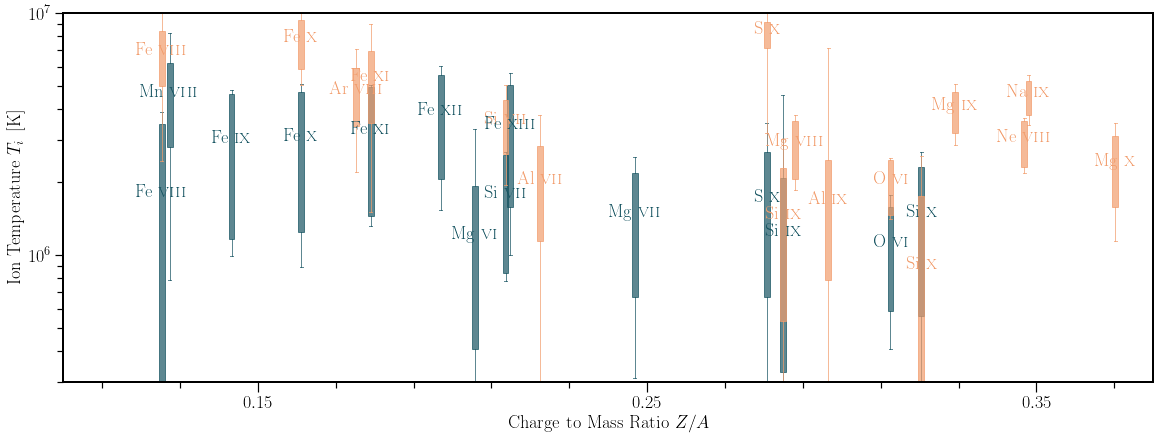

In [9]:
color_sumer = cmcm.batlow(0.75)
color_eis = cmcm.batlow(0.2)
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
eis_boxprops = dict(edgecolor=color_eis,facecolor=color_eis,alpha=0.7)
eis_capprops = dict(color=color_eis,alpha=0.7)
eis_whiskerprops = dict(color=color_eis,alpha=0.7)

sumer_boxprops = dict(edgecolor=color_sumer,facecolor=color_sumer,alpha=0.7)
sumer_capprops = dict(color=color_sumer,alpha=0.7)
sumer_whiskerprops = dict(color=color_sumer,alpha=0.7)

medianprops= dict(linewidth=0)

ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

for ii, row in df_sumer.iterrows():
    ax.text(row["Z2A"],(row["T_min"]+row["T_max"])/2,row["label"],fontsize=18,color=color_sumer,
        ha="center")

for ii, row in df_eis.iterrows():
    ax.text(row["Z2A"],(row["T_min"]+row["T_max"])/2,row["label"],fontsize=18,color=color_eis,
        ha="center")
ax.set_yscale("log")
ax.set_ylim(3e5,1e7)
ax.set_xlim(0.1,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"Ion Temperature $T_i\ \left[\mathrm{K}\right]$",fontsize=18)
ax.set_xlabel(r"Charge to Mass Ratio $Z/A$",fontsize=18)

Text(0.02, 0.03, '\\textbf{*}$\\boldsymbol{\\Delta \\lambda_{\\rm inst, EIS} = 69.7\\,\\mathrm{m}}$\\textbf{\\mbox{\\AA}}')

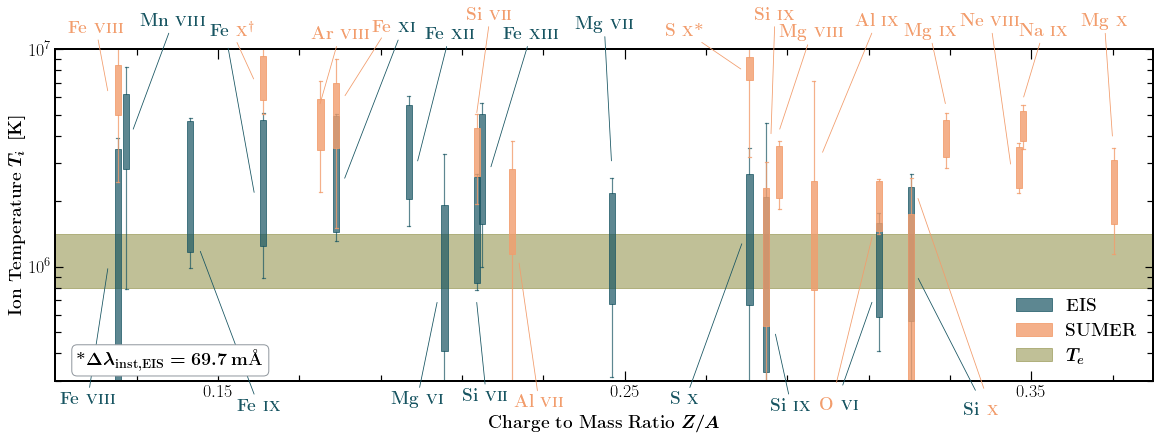

In [10]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)
eis_boxprops = dict(edgecolor=color_eis,facecolor=color_eis,alpha=0.7)
eis_capprops = dict(color=color_eis,alpha=0.7,linewidth=1.2)
eis_whiskerprops = dict(color=color_eis,alpha=0.7,linewidth=1.2)

sumer_boxprops = dict(edgecolor=color_sumer,facecolor=color_sumer,alpha=0.8)
sumer_capprops = dict(color=color_sumer,alpha=0.8,linewidth=1.2)
sumer_whiskerprops = dict(color=color_sumer,alpha=0.8,linewidth=1.2)

medianprops= dict(linewidth=0)

eis_bp = ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

sumer_bp = ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

eis_xycoords = [(0.123,1e6),(0.1455,1.2e6),(0.159,2.15e6),(0.129,4.2e6),
                (0.181,2.5e6),(0.199,3e6),(0.204,7e5),(0.2136,7e5),(0.217,2.82e6),
                (0.2468,3e6),(0.279,1.3e6),(0.287,5e5),(0.311,7e5),(0.322,9e5)]
eis_textcoords = [(0.118,-0.07),(0.16,-0.09),(0.152,1.025),(0.139,1.07),
                (0.195,1.035),(0.207,1.03),(0.199,-0.07),(0.216,-0.06),(0.227,1.03),
                (0.245,1.06),(0.265,-0.07),(0.291,-0.09),(0.303,-0.05),(0.337,-0.06)]
eis_texts = [r"Fe \textsc{viii}",r"Fe \textsc{ix}",r"",r"Mn \textsc{viii}",
            r"",r"Fe \textsc{xii}",r"Mg \textsc{vi}",r"Si \textsc{vii}",r"Fe \textsc{xiii}",
            r"Mg \textsc{vii}",r"S \textsc{x}",r"Si \textsc{ix}",r"",r""]

for ii, text_ in enumerate(eis_texts):
    ax.annotate(r"\textbf{" + text_ + "}",eis_xycoords[ii],eis_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_eis,ha="center",arrowprops=dict(edgecolor=color_eis,arrowstyle="-",lw=0.8))

sumer_xycoords = [(0.123,6.3e6),(0.159,7.15e6),(0.175,5.5e6),(0.181,6e6),(0.2136,5e6),
                (0.224,1.06e6),(0.279,8e6),(0.286,4e6),(0.288,4.2e6),(0.2985,3.29e6),
                (0.311,1.4e6),(0.322,2.1e6),(0.329,5.5e6),(0.345,2.9e6),(0.348,5.9e6),
                (0.37,3.9e6)]
sumer_textcoords = [(0.12,1.05),(0.154,1.025),(0.18,1.03),(0.191,1.035),(0.217,1.09),
                (0.229,-0.08),(0.265,1.04),(0.287,1.09),(0.296,1.035),(0.312,1.07),
                (0.3015,-0.05),(0.339,-0.06),(0.325,1.04),(0.34,1.07),(0.353,1.04),
                (0.368,1.07)]
sumer_texts = [r"Fe \textsc{viii}","",r"Ar \textsc{viii}",r"",r"Si \textsc{vii}",
                r"Al \textsc{vii}",r"S \textsc{x}*",r"Si \textsc{ix}",r"Mg \textsc{viii}",r"Al \textsc{ix}",
                r"",r"",r"Mg \textsc{ix}",r"Ne \textsc{viii}",r"Na \textsc{ix}",
                r"Mg \textsc{x}"]

for ii, text_ in enumerate(sumer_texts):
    ax.annotate(r"\textbf{"+text_+"}",sumer_xycoords[ii],sumer_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_sumer,ha="center",arrowprops=dict(edgecolor=color_sumer,arrowstyle="-",lw=0.8))

rainbow_text(ax,0.148,1.15e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{x}}$\boldsymbol{^\dagger}$"],[color_eis,"white",color_sumer],fontsize=18)
rainbow_text(ax,0.188,1.2e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{xi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.298,2.2e5,[r"\textbf{O}",r"t",r"\textbf{\textsc{vi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.3335,2.1e5,[r"\textbf{Si}",r"t",r"\textbf{\textsc{x}}"],[color_eis,"white",color_sumer],fontsize=18)

te_hspan = ax.axhspan(10**5.9,10**6.15,color=cmcm.batlow(0.5),alpha=0.5,zorder=0)
ax.legend([eis_bp["boxes"][0],sumer_bp["boxes"][0],te_hspan],[r"\textbf{EIS}",r"\textbf{SUMER}",r"$\boldsymbol{T_e}$"],loc="lower right",fontsize=18,frameon=False)
ax.set_yscale("log")
ax.set_ylim(3e5,1e7)
ax.set_xlim(0.11,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18,direction="in",which="both",right=True,top=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"\textbf{Ion Temperature} $\boldsymbol{T_i\ \left[\mathrm{K}\right]}$",fontsize=18)
ax.set_xlabel(r"\textbf{Charge to Mass Ratio} $\boldsymbol{Z/A}$",fontsize=18,labelpad=15)
ax.text(0.02,0.03,r"\textbf{*}$\boldsymbol{\Delta \lambda_{\rm inst, EIS} = 69.7\,\mathrm{m}}$\textbf{\mbox{\AA}}",transform=ax.transAxes,
        ha="left",va="bottom",color="black",fontsize=18,bbox=dict(boxstyle="round", fc="w",ec="#91989F"))
#ax.grid("on",which="both")
# plt.savefig(fname="../../figs/ms/temp_diag.pdf",format="pdf")

### Figure 8
<a id='figure8'></a>

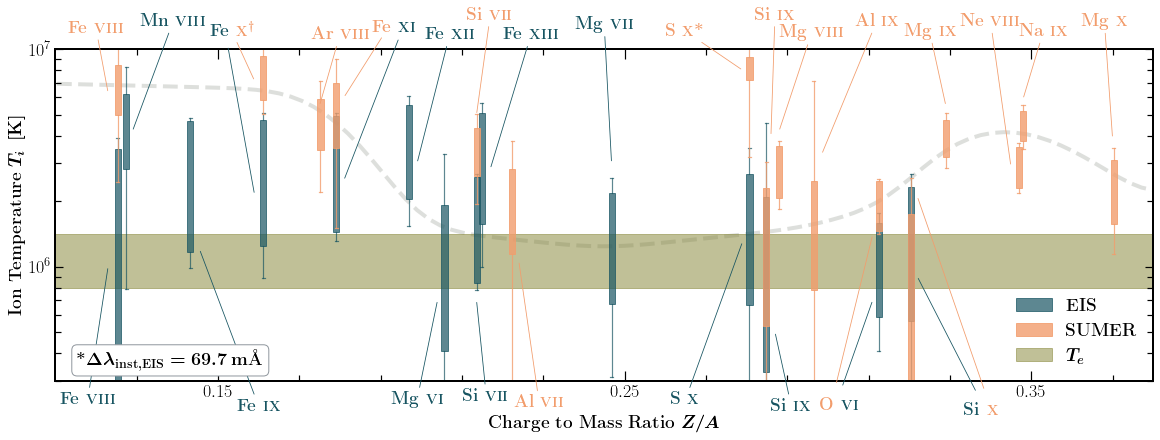

In [11]:
fig, ax = plt.subplots(figsize=(16,6),constrained_layout=True)

eis_bp = ax.bxp(stats_eis,showmeans=False,boxprops=eis_boxprops,capprops=eis_capprops,
        whiskerprops=eis_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_eis,manage_ticks=False)

sumer_bp = ax.bxp(stats_sumer,showmeans=False,boxprops=sumer_boxprops,capprops=sumer_capprops,
        whiskerprops=sumer_whiskerprops,medianprops=medianprops,widths=0.0015,patch_artist=True,
        positions=pos_sumer,manage_ticks=False)

bg_curve_x = np.array([0.1,0.17,0.195,0.245,0.295,0.32,0.33,0.347,0.38])
bg_curve_y = np.array([7e6,6.5e6,1.5e6,1.2e6,1.5e6,2e6,4e6,4.5e6,1.8e6])
bg_curve_x_interp = np.linspace(0.1,0.38,100)
bg_curve_y_interp = np.interp(bg_curve_x_interp,bg_curve_x, bg_curve_y)
bg_smooth = gaussian_filter1d(bg_curve_y_interp,sigma=3)
ax.plot(bg_curve_x_interp, bg_smooth,zorder=0,lw=4,ls='--',color="#BDC0BA",alpha=0.5)

for ii, text_ in enumerate(eis_texts):
    ax.annotate(r"\textbf{" + text_ + "}",eis_xycoords[ii],eis_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_eis,ha="center",arrowprops=dict(edgecolor=color_eis,arrowstyle="-",lw=0.8))


for ii, text_ in enumerate(sumer_texts):
    ax.annotate(r"\textbf{"+text_+"}",sumer_xycoords[ii],sumer_textcoords[ii],xycoords="data",textcoords=("data","axes fraction"),
    fontsize=18,color=color_sumer,ha="center",arrowprops=dict(edgecolor=color_sumer,arrowstyle="-",lw=0.8))

rainbow_text(ax,0.148,1.15e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{x}}$\boldsymbol{^\dagger}$"],[color_eis,"white",color_sumer],fontsize=18)
rainbow_text(ax,0.188,1.2e7,[r"\textbf{Fe}",r"t",r"\textbf{\textsc{xi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.298,2.2e5,[r"\textbf{O}",r"t",r"\textbf{\textsc{vi}}"],[color_sumer,"white",color_eis],fontsize=18)
rainbow_text(ax,0.3335,2.1e5,[r"\textbf{Si}",r"t",r"\textbf{\textsc{x}}"],[color_eis,"white",color_sumer],fontsize=18)

te_hspan = ax.axhspan(10**5.9,10**6.15,color=cmcm.batlow(0.5),alpha=0.5,zorder=0)
ax.legend([eis_bp["boxes"][0],sumer_bp["boxes"][0],te_hspan],[r"\textbf{EIS}",r"\textbf{SUMER}",r"$\boldsymbol{T_e}$"],loc="lower right",fontsize=18,frameon=False)
ax.set_yscale("log")
ax.set_ylim(3e5,1e7)
ax.set_xlim(0.11,0.38)
ax.set_xticks([0.15,0.25,0.35])
ax.tick_params(labelsize=18,direction="in",which="both",right=True,top=True)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_ylabel(r"\textbf{Ion Temperature} $\boldsymbol{T_i\ \left[\mathrm{K}\right]}$",fontsize=18)
ax.set_xlabel(r"\textbf{Charge to Mass Ratio} $\boldsymbol{Z/A}$",fontsize=18,labelpad=15)
ax.text(0.02,0.03,r"\textbf{*}$\boldsymbol{\Delta \lambda_{\rm inst, EIS} = 69.7\,\mathrm{m}}$\textbf{\mbox{\AA}}",transform=ax.transAxes,
        ha="left",va="bottom",color="black",fontsize=18,bbox=dict(boxstyle="round", fc="w",ec="#91989F"))
# plt.savefig(fname="../../figs/ms/temp_diag_ushape.png",format="png")
plt.savefig(fname="../../figs/ms/temp_diag.pdf",format="pdf")

In [12]:
10**(((np.log10(df["T_min"]) + np.log10(df["T_max"]))/2)[25])/1e6

3.371144125409034

In [13]:
df_sort_Z2A = df.sort_values("Z2A")

In [14]:
for index, row in df_sort_Z2A.iterrows():
    print(row["label"],"{:.3f}".format(row["Z2A"]),"T_min","{:.2f} {:.2f} {:.2f}".format(np.log10(row["T_min"]), np.log10(row["T_min"] + row["T_err"]) - np.log10(row["T_min"]),  np.log10(row["T_min"]) - np.log10(row["T_min"] - row["T_err"])))
    print(row["label"],"{:.3f}".format(row["Z2A"]),"T_max","{:.2f} {:.2f} {:.2f}".format(np.log10(row["T_max"]), np.log10(row["T_max"] + row["T_err"]) - np.log10(row["T_max"]),  np.log10(row["T_max"]) - np.log10(row["T_max"] - row["T_err"])))

Fe \textsc{viii} 0.125 T_min -6.47 12.09 nan
Fe \textsc{viii} 0.125 T_max 6.54 0.05 0.05
Fe \textsc{viii} 0.125 T_min 6.70 0.18 0.31
Fe \textsc{viii} 0.125 T_max 6.93 0.11 0.15
Mn \textsc{viii} 0.127 T_min 6.45 0.23 0.55
Mn \textsc{viii} 0.127 T_max 6.79 0.12 0.17
Fe \textsc{ix} 0.143 T_min 6.07 0.06 0.07
Fe \textsc{ix} 0.143 T_max 6.67 0.02 0.02
Fe \textsc{x} 0.161 T_min 6.09 0.11 0.15
Fe \textsc{x} 0.161 T_max 6.67 0.03 0.03
Fe \textsc{x} 0.161 T_min 6.77 0.06 0.07
Fe \textsc{x} 0.161 T_max 6.97 0.04 0.04
Ar \textsc{viii} 0.175 T_min 6.53 0.13 0.19
Ar \textsc{viii} 0.175 T_max 6.77 0.08 0.10
Fe \textsc{xi} 0.179 T_min 6.16 0.04 0.04
Fe \textsc{xi} 0.179 T_max 6.69 0.01 0.01
Fe \textsc{xi} 0.179 T_min 6.54 0.20 0.37
Fe \textsc{xi} 0.179 T_max 6.84 0.11 0.15
Fe \textsc{xii} 0.197 T_min 6.31 0.10 0.13
Fe \textsc{xii} 0.197 T_max 6.74 0.04 0.04
Mg \textsc{vi} 0.206 T_min 5.61 0.64 nan
Mg \textsc{vi} 0.206 T_max 6.28 0.23 0.55
Si \textsc{vii} 0.214 T_min 6.42 0.10 0.13
Si \textsc{vii} 0.2

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
